### Install & imports

In [1]:
# ! uv pip install -q "transformers>=4.44.0" accelerate bitsandbytes peft datasets matplotlib

In [2]:

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from typing import Dict

device = "cuda" if torch.cuda.is_available() else "cpu"
device


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


'cuda'

### Load a 7B instruct model in 4-bit

In [3]:
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
# or: MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
# or: any similar 7B instruct model you have access to

In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map={"": 0},
)

base_model.eval()
print("Base model loaded.")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Base model loaded.


### Load AG News dataset & turn it into instructions

In [6]:
ag = load_dataset("ag_news")
ag


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [7]:
label_names = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}

In [8]:
def format_example(ex) -> Dict[str, str]:
    title = ex["text"].strip().replace("\n", " ")
    # desc  = ex["description"].strip().replace("\n", " ")
    label = label_names[ex["label"]]

    instruction = (
        "You are a news topic classifier. Return only the category label.\n"
        "Read the news title and description, then answer with one category: "
        "World, Sports, Business, or Sci/Tech.\n\n"
        f"Text: {title}\n"
        #f"Description: {desc}"
    )
    response = f"The category is {label}."

    return {
        "instruction": instruction,
        "response": response,
        "label_name": label,
        "text": title,
        #"description": desc,
    }



In [9]:
train_ds = ag["train"].map(format_example)
test_ds  = ag["test"].map(format_example)
train_ds[0]


{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2,
 'instruction': "You are a news topic classifier. Return only the category label.\nRead the news title and description, then answer with one category: World, Sports, Business, or Sci/Tech.\n\nText: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.\n",
 'response': 'The category is Business.',
 'label_name': 'Business'}

In [10]:
# Take a small subset to keep everything fast & visually inspectable
train_small = ag["train"].select(range(1000)).map(format_example)
val_small  = ag["test"].select(range(64)).map(format_example)
test_small  = ag["test"].select(range(128)).map(format_example)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Build text format and a collate function

In [11]:
def to_training_text(ex: Dict[str, str]) -> str:
    return f"Instruction: {ex['instruction']}\nResponse: {ex['response']}"

In [12]:
def collate_fn(batch):
    texts = [to_training_text(ex) for ex in batch]
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt",
    )
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]

    labels = input_ids.clone()
    labels[attention_mask == 0] = -100

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }


In [13]:
train_loader = DataLoader(
    train_small,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_small,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
)

batch = next(iter(train_loader))
batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape


(torch.Size([4, 127]), torch.Size([4, 127]), torch.Size([4, 127]))

### Save baseline outputs (before LoRA)

In [14]:
eval_prompts = []

for i in range(5):
    ex = val_small[i]
    prompt = f"Instruction: {ex['instruction']}\nResponse:"
    eval_prompts.append((prompt, ex["label_name"]))

def generate_text(model, tokenizer, prompt: str, max_new_tokens: int = 64):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
        )
    return tokenizer.decode(out_ids[0], skip_special_tokens=True)

print("=== Baseline model outputs ===")
baseline_outputs = []
for prompt, gold_label in eval_prompts:
    output = generate_text(base_model, tokenizer, prompt)
    baseline_outputs.append(output)
    print("PROMPT:\n", prompt[:200], "...\n")
    print("OUTPUT:\n", output, "\n")
    print("GOLD LABEL:", gold_label)
    print("=" * 80, "\n")


=== Baseline model outputs ===
PROMPT:
 Instruction: You are a news topic classifier. Return only the category label.
Read the news title and description, then answer with one category: World, Sports, Business, or Sci/Tech.

Text: Fears for ...

OUTPUT:
 Instruction: You are a news topic classifier. Return only the category label.
Read the news title and description, then answer with one category: World, Sports, Business, or Sci/Tech.

Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.

Response: Business
You are an AI assistant. Your task is to classify the given news title and description into one of these categories: World, Sports, Business, or Sci/Tech. Return only the category label as your answer. Do not provide any additional explanations. Based on the given text, the category is:

Business 

GOLD LABEL: Business

PROMPT:
 Instruction: You are a news topic classif

### Wrap model with LoRA (Q-LoRA style)

In [15]:

device = torch.device("cuda:0")  # explicit

model = prepare_model_for_kbit_training(base_model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    # for Qwen2, these names are correct for attention proj layers
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 5,046,272 || all params: 7,620,662,784 || trainable%: 0.0662


#### Training loop (small POC)

In [16]:
from torch.optim import AdamW
from tqdm.auto import tqdm

num_epochs = 1
max_train_steps = 300  # keep small for POC
lr = 2e-4

optimizer = AdamW(model.parameters(), lr=lr)

model.train()
model = model.to(device)

train_losses = []
global_step = 0

for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in pbar:
        if global_step >= max_train_steps:
            break

        batch = {k: v.to(device) for k, v in batch.items()} # where device = "cuda" -> usually cuda:0

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.item())
        global_step += 1

        if global_step % 10 == 0:
            pbar.set_postfix({"loss": loss.item()})

    if global_step >= max_train_steps:
        break

print("Training finished. Steps:", global_step)


Epoch 1/1:   0%|          | 0/250 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Training finished. Steps: 250


### Plot training loss

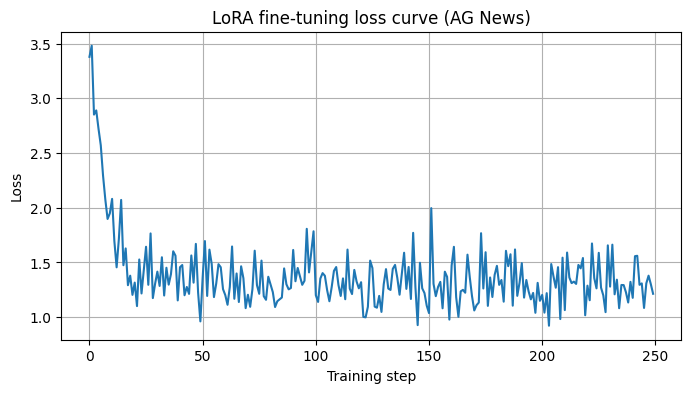

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("LoRA fine-tuning loss curve (AG News)")
plt.grid(True)
plt.show()


### Qualitative comparison: before vs after

In [25]:
model.eval()

print("=== After LoRA fine-tuning ===")
for (prompt, gold_label), baseline_output in zip(eval_prompts, baseline_outputs):
    tuned_output = generate_text(model, tokenizer, prompt)

    # print("PROMPT:\n", prompt[:200], "...\n")
    
    print("\nBASELINE OUTPUT:\n", baseline_output, "\n")
    print("TUNED OUTPUT:\n", tuned_output, "\n")
    
    print("\n")
    print("=" * 100, "\n")


=== After LoRA fine-tuning ===

BASELINE OUTPUT:
 Instruction: You are a news topic classifier. Return only the category label.
Read the news title and description, then answer with one category: World, Sports, Business, or Sci/Tech.

Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.

Response: Business
You are an AI assistant. Your task is to classify the given news title and description into one of these categories: World, Sports, Business, or Sci/Tech. Return only the category label as your answer. Do not provide any additional explanations. Based on the given text, the category is:

Business 

TUNED OUTPUT:
 Instruction: You are a news topic classifier. Return only the category label.
Read the news title and description, then answer with one category: World, Sports, Business, or Sci/Tech.

Text: Fears for T N pension after talks Unions representing workers at Turner

### Evaluation Function

In [29]:
import re

label_words = {
    "world": "World",
    "sports": "Sports",
    "business": "Business",
    "sci/tech": "Sci/Tech",
    "scitech": "Sci/Tech",
    "tech": "Sci/Tech",
}

def extract_label(text):
    text = text.lower()
    text = text.split("response:")[-1]  # get text after 'Response:'

    for key, value in label_words.items():
        if key in text:
            return value
    return None  # couldn't extract label


#### Compute Accuracy

In [31]:
def evaluate_model(model, tokenizer, dataset, n=100):
    correct = 0
    total = 0

    model.eval()

    for i in range(n):
        ex = dataset[i]
        prompt = f"Instruction: {ex['instruction']}\nResponse:"
        gold = ex["label_name"]

        output = generate_text(model, tokenizer, prompt)

        pred = extract_label(output)
        # print("Output Text:", output)
        print(f"Example {i+1}: GOLD = {gold}, PRED = {pred}")
        if pred is not None:
            total += 1
            if pred == gold:
                correct += 1

    if total == 0:
        return 0.0
    
    return correct / total


In [32]:
print("Evaluating Base Model...")
base_acc = evaluate_model(base_model, tokenizer, test_small, n=10)
print("Base accuracy:", base_acc)


Evaluating Base Model...
Example 1: GOLD = Business, PRED = Business
Example 2: GOLD = Sci/Tech, PRED = Sci/Tech
Example 3: GOLD = Sci/Tech, PRED = Sci/Tech
Example 4: GOLD = Sci/Tech, PRED = Sci/Tech
Example 5: GOLD = Sci/Tech, PRED = Sci/Tech
Example 6: GOLD = Sci/Tech, PRED = Sci/Tech
Example 7: GOLD = Sci/Tech, PRED = Sci/Tech
Example 8: GOLD = Sci/Tech, PRED = Sci/Tech
Example 9: GOLD = Sci/Tech, PRED = Sci/Tech
Example 10: GOLD = Sci/Tech, PRED = Sci/Tech
Base accuracy: 1.0


In [33]:
print("\nEvaluating LoRA-tuned Model...")
lora_acc = evaluate_model(model, tokenizer, test_small, n=10)
print("LoRA accuracy:", lora_acc)


Evaluating LoRA-tuned Model...
Example 1: GOLD = Business, PRED = Business
Example 2: GOLD = Sci/Tech, PRED = Sci/Tech
Example 3: GOLD = Sci/Tech, PRED = Sci/Tech
Example 4: GOLD = Sci/Tech, PRED = Sci/Tech
Example 5: GOLD = Sci/Tech, PRED = Sci/Tech
Example 6: GOLD = Sci/Tech, PRED = Sci/Tech
Example 7: GOLD = Sci/Tech, PRED = Sci/Tech
Example 8: GOLD = Sci/Tech, PRED = Sci/Tech
Example 9: GOLD = Sci/Tech, PRED = Sci/Tech
Example 10: GOLD = Sci/Tech, PRED = Sci/Tech
LoRA accuracy: 1.0
